In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertTokenizer, BertConfig, BertModel,AutoTokenizer, AutoConfig, AutoModel
# import transformers

In [2]:
# Setup device-agnostic code 

if torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps") # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print(torch.__version__)
np.random.seed(42)
torch.manual_seed(42)

MAX_LEN = 40
NUM_LABELS = 39
BATCH_SIZE = 8

2.2.2


In [4]:
IN_DATA_FILE = "./data/occupations_augmented.csv"
# TRAIN_DATASET = "./data/csv/train_df.csv"
# VALIDATION_DATASET = "./data/csv/val_df.csv"
# TEST_DATASET = "./data/csv/test_df.csv"
# DEVELOPMENT_DATASET = "./data/csv/dev_df.csv"

In [5]:
# MODEL = "sentence-transformers/paraphrase-mpnet-base-v2"
# IN_DATA_FILE = "./data/csv/train_df.csv"
# TRAIN_DATASET = "./data/csv/train_df.csv"

df_labelled = pd.read_csv(IN_DATA_FILE)
df_labelled.head()

,code,text,label_text,label
0,451813,Sex Worker Escort 'Sex Worker Escort';'Domin...,Adult Industry Workers,0
1,451813,Sex Worker Escort 'Sex Worker Escort';Person...,Adult Industry Workers,0
2,451813,Sex Worker Escort Escort Service;'Dominatrix'...,Adult Industry Workers,0
3,451813,Sex Worker Escort 'Sex Worker Escort';Sex Wo...,Adult Industry Workers,0
4,451813,Sex Worker Escort 'Sex Worker Escort';'Prost...,Adult Industry Workers,0


In [6]:
label_list = df_labelled.loc[:,'label'].tolist()
# label_list

In [7]:
import re
import string
punc_str = string.punctuation+'\n'
sent_list = df_labelled['text'].str.lower().tolist()
MAX_LEN = 20
comp = re.compile('[^A-Z^a-z^0-9^ ]')
for i in range(len(sent_list)):
    tmp_str = sent_list[i].replace(r";",r"' '").lstrip()
    tmp_str = tmp_str.translate(str.maketrans('','',punc_str))
    tmp_str = comp.sub('', tmp_str)
    tmp_str = ' '.join(tmp_str.split())
    tmp_list = set(tmp_str.split(' ')[:MAX_LEN])
    sent_list[i] = ' '.join(tmp_list)

# sent_list

In [8]:
df_labelled['text'] = sent_list
df_labelled

,code,text,label_text,label
0,451813,worker workers dominatrix personal prostitute ...,Adult Industry Workers,0
1,451813,worker workers personal and service travel oth...,Adult Industry Workers,0
2,451813,worker workers dominatrix community personal a...,Adult Industry Workers,0
3,451813,worker workers dominatrix personal service oth...,Adult Industry Workers,0
4,451813,worker workers prostitute personal dominatrix ...,Adult Industry Workers,0
...,...,...,...,...
2217,733111,cement haulpak rubbish general livestock truck...,Truck Drivers,38
2218,733114,tanker operators water milk truck and petrol m...,Truck Drivers,38
2219,733114,tanker operators water milk truck and petrol m...,Truck Drivers,38
2220,733115,tow army operators truck recovery and machiner...,Truck Drivers,38


<Axes: xlabel='label'>

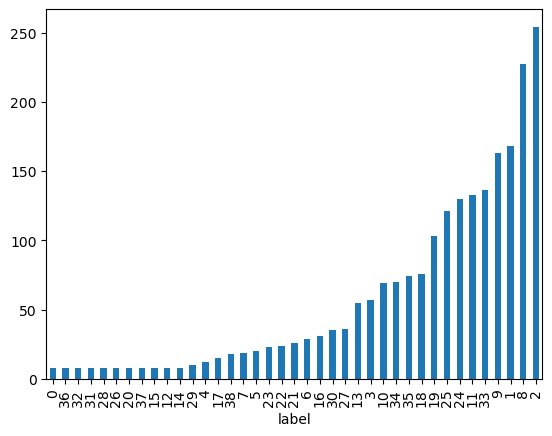

In [9]:
df_labelled.groupby(['label']).size().sort_values().plot.bar()

In [10]:
df_labelled

,code,text,label_text,label
0,451813,worker workers dominatrix personal prostitute ...,Adult Industry Workers,0
1,451813,worker workers personal and service travel oth...,Adult Industry Workers,0
2,451813,worker workers dominatrix community personal a...,Adult Industry Workers,0
3,451813,worker workers dominatrix personal service oth...,Adult Industry Workers,0
4,451813,worker workers prostitute personal dominatrix ...,Adult Industry Workers,0
...,...,...,...,...
2217,733111,cement haulpak rubbish general livestock truck...,Truck Drivers,38
2218,733114,tanker operators water milk truck and petrol m...,Truck Drivers,38
2219,733114,tanker operators water milk truck and petrol m...,Truck Drivers,38
2220,733115,tow army operators truck recovery and machiner...,Truck Drivers,38


In [11]:
guides = sorted(df_labelled.label_text.unique().tolist())
# id2id = {v:k for k, v in enumerate(guides)}
id2label = {k:v for k, v in enumerate(guides)}
# lazy method in case df does not have all labels
label2id = {
  'Adult Industry Workers': 0,
 'Agricultural Workers': 1,
 'Australian Defence Force Members': 2,
 'Building And Construction Employees': 3,
 'Bus Drivers': 4,
 'Call Centre Operators': 5,
 'Cleaners': 6,
 'Community Support Workers And Direct Carers': 7,
 'Doctor, Specialist Or Other Medical Professional': 8,
 'Employee Tradesperson': 9,
 'Engineers': 10,
 'Factory Workers': 11,
 'Fire Fighters': 12,
 'Fitness And Sporting Industry Employees': 13,
 'Flight Crew': 14,
 'Gaming Attendants': 15,
 'Guards And Security Employees': 16,
 'Hairdressers And Beauty Professionals': 17,
 'Hospitality Industry Employees': 18,
 'It Professionals': 19,
 'Lawyers': 20,
 'Meat Workers': 21,
 'Media Professionals': 22,
 'Mining Site Employees': 23,
 'Nurses And Midwives': 24,
 'Office Workers': 25,
 'Paramedics': 26,
 'Performing Artists': 27,
 'Pilots': 28,
 'Police': 29,
 'Professional Sportsperson': 30,
 'Real Estate Employees': 31,
 'Recruitment Consultants': 32,
 'Retail Industry Workers': 33,
 'Sales And Marketing': 34,
 'Teachers And Education Professionals': 35,
 'Train Drivers': 36,
 'Travel Agent Employees': 37,
 'Truck Drivers': 38}

In [12]:
# from transformers import BertConfig, BertModel, BertTokenizer

# MODEL = '/Users/tod/Desktop/set_fit/cache_dir/sentence-transformers_all-MiniLM-L6-v2'
# bert_config = BertConfig.from_pretrained(MODEL)
# bert = BertModel(bert_config)
# bert.load_state_dict(torch.load("cache_dir/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin"))
# print(bert)

In [13]:
MODEL = 'paraphrase-MiniLM-L6-v2'
# MODEL = 'sentence-transformers/all-mpnet-base-v2'
# MODEL = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
# MODEL = 'Alibaba-NLP/gte-base-en-v1.5'

# from transformers import BertModel
# from transformers import DistilBertModel
# from transformers import RobertaModel
# base = RobertaModel.from_pretrained(MODEL)
# bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')
# MODEL = 'chavinlo/alpaca-native'
# MODEL = 'distilbert-base-uncased'
# MODEL = 'roberta-base'
# MODEL = 'bert-base-cased'
# from transformers import BertTokenizer
# from transformers import DistilBertTokenizerFast
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# from transformers import RobertaTokenizer
# tokenizer = RobertaTokenizer.from_pretrained(MODEL)
# tokenizer = BertTokenizer.from_pretrained(MODEL)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

class Dataset(Dataset):

    def __init__(self, df):
        self.labels = df.label.to_list()
        self.encodings = tokenizer(df.text.to_list(), 
                        padding='max_length', 
                        max_length = MAX_LEN, 
                        truncation=True,
                        return_tensors="pt"
                        )

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [14]:
# import transformers
# print(transformers.__version__)

In [15]:
# from transformers import AutoTokenizer
# sentences = df.text.to_list()
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# max_tokens = 0
# for sentence in sentences:
#     num_tokens = len(tokenizer.tokenize(sentence))
#     if num_tokens > max_tokens:
#         max_tokens = num_tokens
# max_tokens


In [16]:
# X_train,X_test, y_train, y_test = \
# train_test_split(df['text'].tolist(), df['label'].tolist()
# shuffle = True, test_size=0.1, random_state=42, stratify=df['label'])

In [17]:
df_train, df_val, df_test = np.split(df_labelled.sample(frac=1, random_state=42), 
                            [int(.8*len(df_labelled)), int(.9*len(df_labelled))])

print(len(df_train),len(df_val), len(df_test))

1777 222 223


/opt/homebrew/Caskroom/miniforge/base/envs/nlp_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
df_train

,code,text,label_text,label
96,841215,garden vegetable crop workers picker and farm ...,Agricultural Workers,1
2208,732111,deliverer operators food and meals taxitruck m...,Truck Drivers,38
1942,621111,sales theatre general workers food assistant a...,Retail Industry Workers,33
1874,452453,workers community personal and sportspersons s...,Professional Sportsperson,30
1803,211111,dancers professionals voiceover actor artist a...,Performing Artists,27
...,...,...,...,...
1119,839312,timber worker vegetable grader workers milk cl...,Factory Workers,11
801,321211,workers general automotive motor technicians a...,Employee Tradesperson,9
1774,591113,clerks workers and procurement officer purchas...,Office Workers,25
512,561911,centre call classified workers and ads operato...,Call Centre Operators,5


### Balance classes by sampling all labels with replacement

In [19]:
SAMPLES_PER_LABEL = 15
guide_grp = df_train.groupby('label')
df_train_aug = pd.DataFrame(columns=['code', 'text', ])

for grp in guide_grp:
    if grp[1].shape[0] > SAMPLES_PER_LABEL:
        tmp_df = grp[1]
    else:
        # augment low count labels
        tmp_df = grp[1].sample(n=SAMPLES_PER_LABEL, replace = True, random_state=42)
    df_train_aug = pd.concat([df_train_aug, tmp_df], ignore_index=True)

df_train_aug = df_train_aug.sample(frac = 1) # shuffle rows
df_train_aug.shape

(1888, 4)

In [20]:
class BertClassifier(nn.Module):

    def __init__(self, MODEL, classify_last_hidden_state=True):

        super(BertClassifier, self).__init__()

        # self.config = BertConfig.from_pretrained(MODEL, 
        #                                         return_dict=True,
        #                                         output_attention = True, 
        #                                         output_hidden_state = True,
        #                                         output_hidden_states = False)
        
        # self.base = BertModel.from_pretrained(MODEL, config=self.config)
        self.config = AutoConfig.from_pretrained(MODEL, 
                                                return_dict=True,
                                                output_attention = True, 
                                                output_hidden_state = True,
                                                output_hidden_states = False)
        
        self.base = AutoModel.from_pretrained(MODEL, config=self.config)

        self.hidden_size = self.base.config.to_dict()['hidden_size']

        # self.base = AutoModel.from_pretrained(MODEL,return_dict=True)

        # self.classifier = nn.Sequential(
        #         nn.Dropout(0.4),
        #         nn.Linear(self.hidden_size, NUM_LABELS),
        #     )
        
        self.classifier = nn.Sequential(
          nn.Linear(self.hidden_size, self.hidden_size),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(self.hidden_size, NUM_LABELS),
        )
        self.classify_last_hidden_state = classify_last_hidden_state

    def mean_pooling1(self, base_hidden_state, mask):
        input_mask_expanded = mask.unsqueeze(-1).expand(base_hidden_state.size()).float()
        return torch.sum(base_hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def mean_pooling2(self, base_hidden_state, mask):
        x = torch.squeeze(
                        torch.matmul(
                        mask.type(torch.float32).view(-1,1,MAX_LEN),
                        base_hidden_state
                        ),
                    1)
        return x

    def forward(self, input_id, mask):
        bert_output = self.base(input_ids = input_id, attention_mask = mask)
        # print(f"{bert_output=}")
        if self.classify_last_hidden_state:
            # base_hidden_state = bert_output[0]
            base_hidden_state = bert_output.last_hidden_state
            # sentence_embeddings = mean_pooling1(base_hidden_state, mask)
            sentence_embeddings = self.mean_pooling2(base_hidden_state, mask)
            # hidden_states = bert_output[2]
            # print(f"{hidden_states.shape=}")

            # sentence_embeddings = torch.cat(tuple([mean_pooling2(hidden_states[i],mask) for i in [-4, -3, -2, -1]]), dim=-1)

            # print(f"{sentence_embeddings.shape=}")
        else:
            # sentence_embeddings = bert_output[1]
            sentence_embeddings = bert_output.pooler_output

        return self.classifier(sentence_embeddings)
    
model = BertClassifier(MODEL, classify_last_hidden_state=True)

print('Model=\n',model,'\n')
    

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model=
 BertClassifier(
  (base): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [21]:
def print_trainable_parameters(model):

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params/1e6:.2f} million || all params: {all_param/1e6:.2f} million || trainable%: {trainable_params / all_param:.2%}"
    )

print_trainable_parameters(model)

trainable params: 278.66 million || all params: 278.66 million || trainable%: 100.00%


In [22]:
from torch.utils.data.sampler import WeightedRandomSampler

def get_weights(df):
     class_sample_count = df.label.value_counts()
     weight = np.array(1. / class_sample_count)
     return torch.tensor(weight[df.label.values], dtype=torch.float32)

sample_weights = get_weights(df_train)
# upsample minority classes
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [23]:
EPOCHS = 10
opt_dict = {'SGD':True, 'base':1e-6, 'classifier':1e-3}


# Function to calcuate the accuracy of the model
def calc_batch_correct(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct


def train_batch(batch, criterion, optimizer):
    # Set the model to train mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()
    
    # free up cache
    torch.mps.empty_cache()

    # Prepare data
    train_label = batch['labels'].to(device)
    mask = batch['attention_mask'].to(device)
    input_id = batch['input_ids'].squeeze(1).to(device)

    # Forward pass
    output = model(input_id, mask)

    # Compute the loss
    batch_loss = criterion(output, train_label)

    batch_correct = calc_batch_correct(output.argmax(dim=1), train_label)

    # Backward pass
    batch_loss.backward()

    # Update the parameters
    optimizer.step()

    # Update learning rate
    # scheduler.step()

    # Return the loss
    return batch_loss.item(), batch_correct


def evaluate_batch(batch, criterion):
    # Set the model to train mode
    model.eval()

    # Prepare data
    val_label = batch['labels'].to(device)
    mask = batch['attention_mask'].to(device)
    input_id = batch['input_ids'].squeeze(1).to(device)

    # Forward pass
    output = model(input_id, mask)

    # Compute the loss
    batch_loss = criterion(output, val_label).item()

    batch_correct = calc_batch_correct(output.argmax(dim=1), val_label)

    return batch_loss, batch_correct


def process_an_epoch(train_dataloader, val_dataloader, criterion, optimizer):
    total_correct_train = 0
    total_loss_train = 0
    model.train()

    for batch in tqdm(train_dataloader):

        batch_loss, batch_correct = train_batch(batch, criterion, optimizer)

        total_loss_train += batch_loss
        total_correct_train += batch_correct

    total_correct_val = 0
    total_loss_val = 0
    model.eval()

    with torch.no_grad():

        for batch in val_dataloader:

            batch_loss, batch_correct = evaluate_batch(batch, criterion)

            total_loss_val += batch_loss                   
            total_correct_val += batch_correct
    return total_loss_train, total_correct_train, total_loss_val, total_correct_val


def train(model, train_data, val_data, opt_dict, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, sampler=sampler)

    # train_dataloader = DataLoader(train, batch_size = BATCH_SIZE, shuffle=True)
    
    val_dataloader = DataLoader(val, batch_size = BATCH_SIZE)

    # criterion = nn.CrossEntropyLoss(weights=class_weights)
    criterion = nn.CrossEntropyLoss()

    if (opt_dict['SGD']):
        optimizer = torch.optim.SGD(
            [{'params': filter(lambda p: p.requires_grad, model.base.parameters()), 'lr':opt_dict['base'], },
            {'params': filter(lambda p: p.requires_grad, model.classifier.parameters())}], 
            lr=opt_dict['classifier'], 
            momentum=0.95, 
            weight_decay=1e-5
        )
    else:
        optimizer = AdamW(
            [{'params': filter(lambda p: p.requires_grad, model.base.parameters()), 
            'lr':opt_dict['base'], },
            {'params': filter(lambda p: p.requires_grad, model.classifier.parameters())}], 
            lr= opt_dict['classifier'])


    model.to(device)
    criterion.to(device)


    history = {}  # epoch history
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []
    history['epochs'] = []


    for epoch_num in range(epochs):

            total_loss_train, total_correct_train, total_loss_val, total_correct_val =\
                process_an_epoch(train_dataloader, val_dataloader, criterion, optimizer)
            
            history['train_loss'].append(total_loss_train/ len(train_data))
            history['train_accuracy'].append(total_correct_train/len(train_data))
            history['val_loss'].append(total_loss_val/ len(val_data))
            history['val_accuracy'].append(total_correct_val/len(val_data))
            history['epochs'].append(epoch_num)

            # report epoch statistics
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {100*total_correct_train / len(train_data): .2f}% \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {100*total_correct_val / len(val_data): .2f}%')
            
    return history
                  

In [24]:
# freeze/unfreeze all the parameters in base model
for param in model.base.parameters():
    param.requires_grad = True
# freeze/unfreeze all the parameters in classifier head
for param in model.classifier.parameters():
    param.requires_grad = True
              
history = train(model, df_train, df_val, opt_dict, EPOCHS)
# train(model, df_train_aug, df_val, opt_dict, EPOCHS)

100%|██████████| 223/223 [00:53<00:00,  4.17it/s]


Epochs: 1 | Train Loss:  0.128                 | Train Accuracy:  75.13%                 | Val Loss:  0.092                 | Val Accuracy:  81.08%


100%|██████████| 223/223 [00:50<00:00,  4.45it/s]


Epochs: 2 | Train Loss:  0.041                 | Train Accuracy:  91.73%                 | Val Loss:  0.075                 | Val Accuracy:  83.78%


100%|██████████| 223/223 [00:51<00:00,  4.33it/s]


Epochs: 3 | Train Loss:  0.031                 | Train Accuracy:  93.42%                 | Val Loss:  0.062                 | Val Accuracy:  83.78%


100%|██████████| 223/223 [00:49<00:00,  4.48it/s]


Epochs: 4 | Train Loss:  0.030                 | Train Accuracy:  93.64%                 | Val Loss:  0.042                 | Val Accuracy:  90.54%


100%|██████████| 223/223 [00:49<00:00,  4.49it/s]


Epochs: 5 | Train Loss:  0.020                 | Train Accuracy:  95.05%                 | Val Loss:  0.044                 | Val Accuracy:  89.64%


100%|██████████| 223/223 [00:49<00:00,  4.49it/s]


Epochs: 6 | Train Loss:  0.021                 | Train Accuracy:  95.22%                 | Val Loss:  0.056                 | Val Accuracy:  89.64%


100%|██████████| 223/223 [00:49<00:00,  4.49it/s]


Epochs: 7 | Train Loss:  0.019                 | Train Accuracy:  95.55%                 | Val Loss:  0.062                 | Val Accuracy:  87.39%


100%|██████████| 223/223 [00:49<00:00,  4.48it/s]


Epochs: 8 | Train Loss:  0.017                 | Train Accuracy:  96.23%                 | Val Loss:  0.050                 | Val Accuracy:  88.74%


100%|██████████| 223/223 [00:49<00:00,  4.47it/s]


Epochs: 9 | Train Loss:  0.014                 | Train Accuracy:  96.51%                 | Val Loss:  0.039                 | Val Accuracy:  91.89%


100%|██████████| 223/223 [00:49<00:00,  4.50it/s]


Epochs: 10 | Train Loss:  0.010                 | Train Accuracy:  97.86%                 | Val Loss:  0.036                 | Val Accuracy:  92.79%


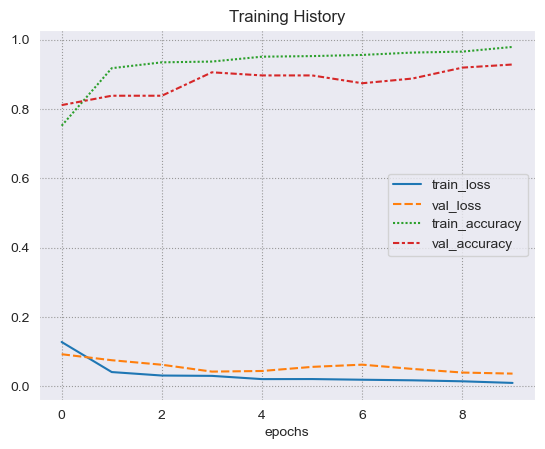

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
g = sns.lineplot(data=pd.DataFrame(history).set_index('epochs'))
g.set_title("Training History")

# Show plot
plt.show()

In [26]:
from sklearn.metrics import (f1_score, 
                             accuracy_score,
                             classification_report,
                             confusion_matrix
                            )

id2label = {
 0: 'Adult Industry Workers',
 1: 'Agricultural Workers',
 2: 'Australian Defence Force Members',
 3: 'Building And Construction Employees',
 4: 'Bus Drivers',
 5: 'Call Centre Operators',
 6: 'Cleaners',
 7: 'Community Support Workers And Direct Carers',
 8: 'Doctor, Specialist Or Other Medical Professional',
 9: 'Employee Tradesperson',
 10: 'Engineers',
 11: 'Factory Workers',
 12: 'Fire Fighters',
 13: 'Fitness And Sporting Industry Employees',
 14: 'Flight Crew',
 15: 'Gaming Attendants',
 16: 'Guards And Security Employees',
 17: 'Hairdressers And Beauty Professionals',
 18: 'Hospitality Industry Employees',
 19: 'It Professionals',
 20: 'Lawyers',
 21: 'Meat Workers',
 22: 'Media Professionals',
 23: 'Mining Site Employees',
 24: 'Nurses And Midwives',
 25: 'Office Workers',
 26: 'Paramedics',
 27: 'Performing Artists',
 28: 'Pilots',
 29: 'Police',
 30: 'Professional Sportsperson',
 31: 'Real Estate Employees',
 32: 'Recruitment Consultants',
 33: 'Retail Industry Workers',
 34: 'Sales And Marketing',
 35: 'Teachers And Education Professionals',
 36: 'Train Drivers',
 37: 'Travel Agent Employees',
 38: 'Truck Drivers'
}

def multiclass_evaluation(model, test_data):

    test = Dataset(test_data)

    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)

    model.to(device)
    model.eval()

    labels = np.array([], dtype=int)
    preds  = np.array([], dtype=int)

    with torch.no_grad():

        for batch in test_dataloader:

            mask = batch['attention_mask'].to(device)
            input_id = batch['input_ids'].squeeze(1).to(device)
            # input_id = batch['input_ids'].to(device)
            test_label = batch['labels'].cpu().numpy()
            pred = model(input_id, mask).argmax(dim=1).cpu().numpy()

            labels = np.concatenate((labels, test_label),axis=0)
            preds = np.concatenate((preds, pred),axis=0)
    
    return labels, preds, confusion_matrix(labels, preds)


labels, preds, cm = multiclass_evaluation(model, df_test)

# accuracy = 100*(preds == labels).sum()/len(labels)

# print(f"Test Accuracy:{accuracy:0.2f}%")

labels, preds, cm = multiclass_evaluation(model, df_test)
target_names = [id2label[id] for id in set(labels).union(set(preds))]
print(classification_report(labels, preds, target_names=target_names,zero_division=0))

                                                  precision    recall  f1-score   support

                          Adult Industry Workers       0.00      0.00      0.00         1
                            Agricultural Workers       1.00      1.00      1.00        11
                Australian Defence Force Members       0.95      0.91      0.93        23
             Building And Construction Employees       1.00      0.67      0.80         6
                                     Bus Drivers       1.00      0.50      0.67         2
                           Call Centre Operators       1.00      1.00      1.00         1
                                        Cleaners       1.00      1.00      1.00         1
     Community Support Workers And Direct Carers       1.00      0.67      0.80         3
Doctor, Specialist Or Other Medical Professional       0.95      0.95      0.95        20
                           Employee Tradesperson       0.76      0.93      0.84        14
         

<Axes: >

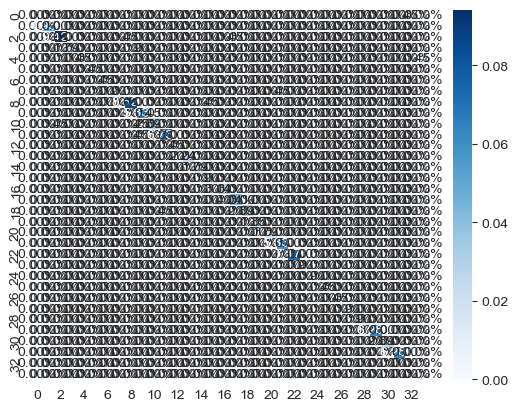

In [27]:
cm.shape
import seaborn as sns
sns.heatmap(cm/np.sum(cm), 
            annot=True, 
            fmt='.2%', 
            cmap='Blues')